In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
dir_bcast = '../results/bcast/'
dir_scatter = '../results/scatter/'
out_dir = '../plots/'

In [3]:
s_df0 = pd.read_csv(f'{dir_scatter}fixed_size/scatter0_fixed_core.csv')
s_df1 = pd.read_csv(f'{dir_scatter}fixed_size/scatter1_fixed_core.csv')
s_df2 = pd.read_csv(f'{dir_scatter}fixed_size/scatter2_fixed_core.csv')
s_df3 = pd.read_csv(f'{dir_scatter}fixed_size/scatter3_fixed_core.csv')


In [4]:
b_df0 = pd.read_csv(f'{dir_bcast}fixed_size/bcast0_fixed_core.csv')
b_df1 = pd.read_csv(f'{dir_bcast}fixed_size/bcast1_fixed_core.csv')
b_df3 = pd.read_csv(f'{dir_bcast}fixed_size/bcast3_fixed_core.csv')
b_df5 = pd.read_csv(f'{dir_bcast}fixed_size/bcast5_fixed_core.csv')

In [5]:
df_b_map0 = pd.read_csv(f'{dir_bcast}var_size/bcast0_core_mapping_epyc.csv') # default
df_b_map1 = pd.read_csv(f'{dir_bcast}var_size/bcast1_core_mapping_epyc.csv') # basic linear
df_b_map3 = pd.read_csv(f'{dir_bcast}var_size/bcast3_core_mapping_epyc.csv') # pipeline
df_b_map5 = pd.read_csv(f'{dir_bcast}var_size/bcast5_core_mapping_epyc.csv') # binary tree

df_s_map0 = pd.read_csv(f'{dir_scatter}var_size/scatter0_core_mapping_epyc.csv') # default
df_s_map1 = pd.read_csv(f'{dir_scatter}var_size/scatter1_core_mapping_epyc.csv') # basic linear
df_s_map2 = pd.read_csv(f'{dir_scatter}var_size/scatter2_core_mapping_epyc.csv') # binomial
df_s_map3 = pd.read_csv(f'{dir_scatter}var_size/scatter3_core_mapping_epyc.csv') # linear_nb

In [6]:
# Calculate latency differences and apply a logarithmic transformation
def log_transform_diff(diff):
    # Apply log transformation while preserving the sign of the difference
    return np.sign(diff) * np.log1p(np.abs(diff)) / np.log(10)  # np.log1p for log(1 + x) to handle small differences

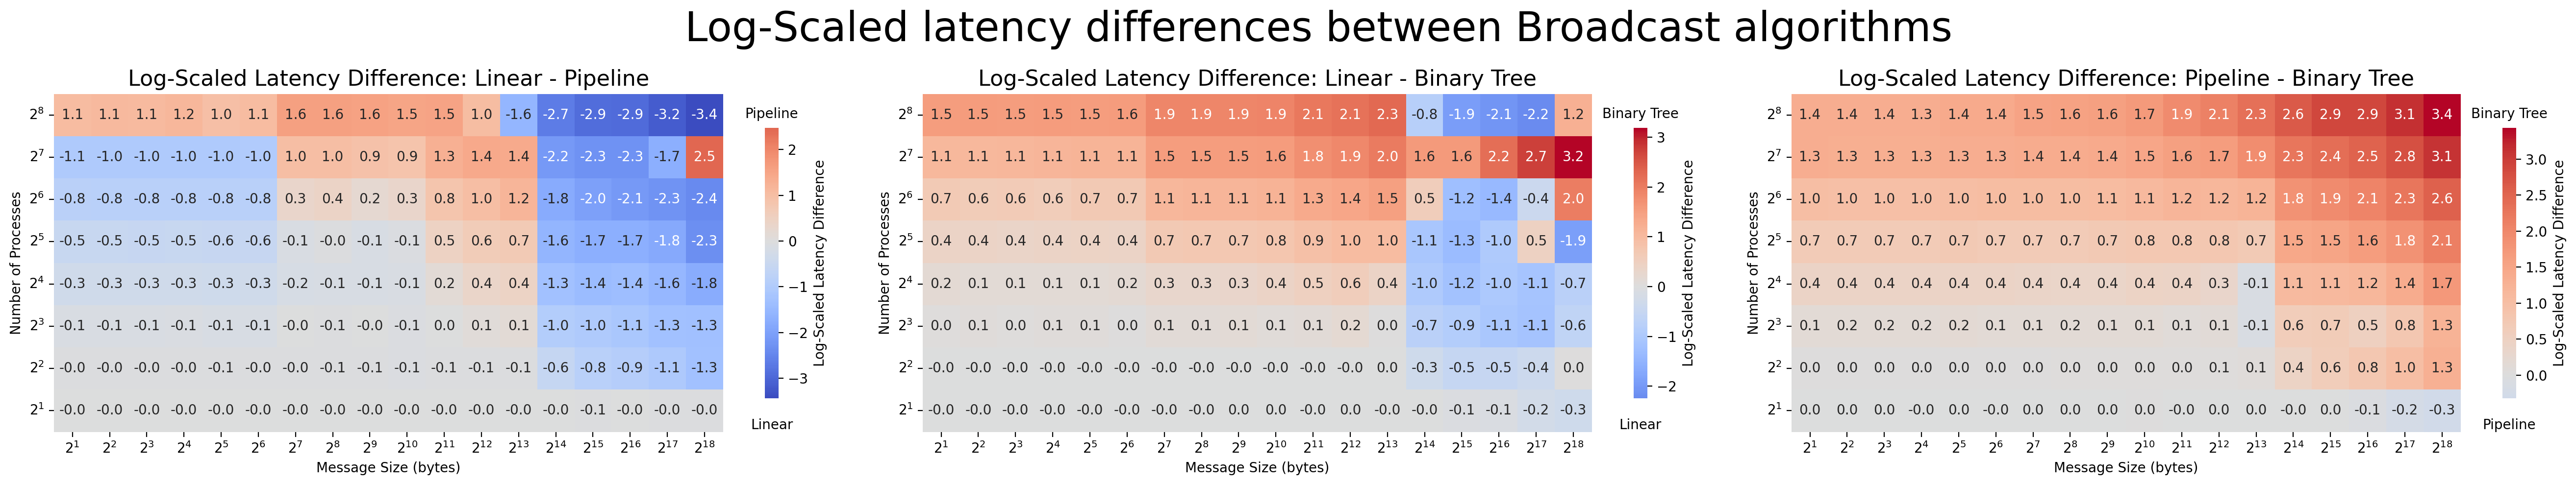

In [7]:

# Merge datasets on Processes and Size
merged_df = df_b_map1.merge(df_b_map3, on=['Processes', 'Size'], suffixes=('_linear', '_pipeline'))
merged_df = merged_df.merge(df_b_map5, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_binary_tree'})

merged_df['linear_vs_pipeline'] = log_transform_diff(merged_df['Latency_linear'] - merged_df['Latency_pipeline'])
merged_df['linear_vs_binary_tree'] = log_transform_diff(merged_df['Latency_linear'] - merged_df['Latency_binary_tree'])
merged_df['pipeline_vs_binary_tree'] = log_transform_diff(merged_df['Latency_pipeline'] - merged_df['Latency_binary_tree'])

# Create pivot tables for each comparison to use in the heatmap
pivot_linear_pipeline = merged_df.pivot(index='Processes', columns='Size', values='linear_vs_pipeline')
pivot_linear_binary = merged_df.pivot(index='Processes', columns='Size', values='linear_vs_binary_tree')
pivot_pipeline_binary = merged_df.pivot(index='Processes', columns='Size', values='pipeline_vs_binary_tree')

# Define a color map with a centered color at zero for logarithmic scale
fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)

# Plot each comparison with a logarithmic scale
cbar_kws = {'shrink': 0.8}  # Optionally adjust the size of the color bar

# Linear - Pipeline
heatmap1 = sns.heatmap(
    pivot_linear_pipeline,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar_kws=cbar_kws
)
cbar = heatmap1.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Pipeline', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Linear', ha='center', va='center', transform=cbar.ax.transAxes)
axes[0].set_title('Log-Scaled Latency Difference: Linear - Pipeline', size=16)
axes[0].set_xlabel('Message Size (bytes)')
axes[0].set_ylabel('Number of Processes')

# Linear - Binary Tree
heatmap2 = sns.heatmap(
    pivot_linear_binary,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[1],
    cbar_kws=cbar_kws
)
cbar = heatmap2.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')
cbar.ax.text(0.5, 1.05, 'Binary Tree', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Linear', ha='center', va='center', transform=cbar.ax.transAxes)
axes[1].set_title('Log-Scaled Latency Difference: Linear - Binary Tree', size=16)
axes[1].set_xlabel('Message Size (bytes)')
axes[1].set_ylabel('Number of Processes')

# Pipeline - Binary Tree
heatmap3 = sns.heatmap(
    pivot_pipeline_binary,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[2],
    cbar_kws=cbar_kws
)
cbar = heatmap3.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')
cbar.ax.text(0.5, 1.05, 'Binary Tree', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Pipeline', ha='center', va='center', transform=cbar.ax.transAxes)
axes[2].set_title('Log-Scaled Latency Difference: Pipeline - Binary Tree', size=16)
axes[2].set_xlabel('Message Size (bytes)')
axes[2].set_ylabel('Number of Processes')

# Invert the y-axis for each subplot and set x and y ticks as powers of 2
for ax in axes:
    ax.invert_yaxis()
    
    # Set x and y ticks to powers of 2
    x_ticks = pivot_linear_pipeline.columns
    y_ticks = pivot_linear_pipeline.index
    
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

plt.suptitle('Log-Scaled latency differences between Broadcast algorithms', fontsize=30)
plt.tight_layout()
plt.savefig(f'{out_dir}log_scaled_heatmap_broadcast.png')
plt.show()


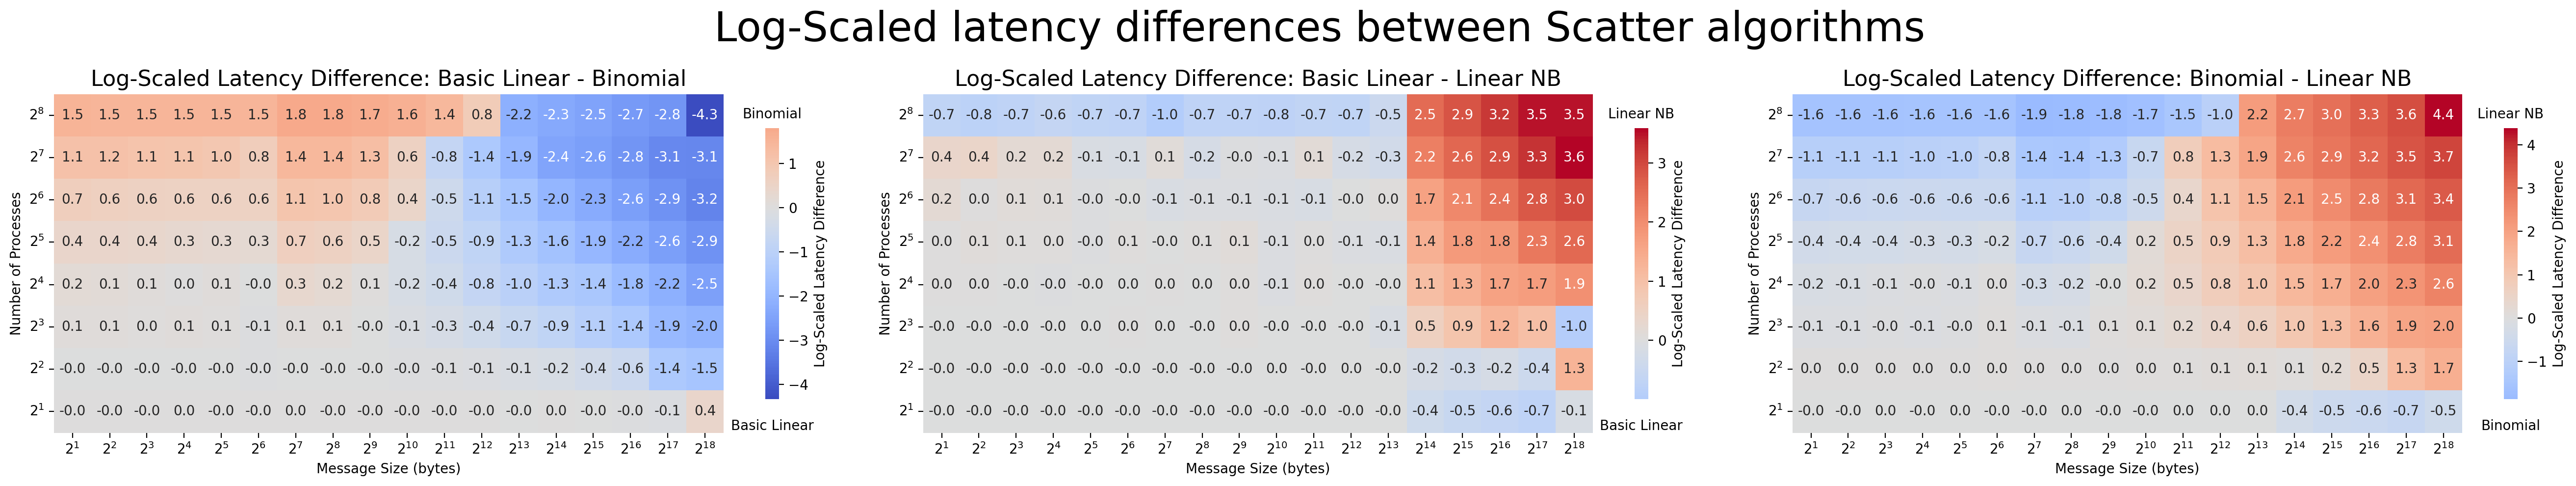

In [8]:
# Merge datasets on Processes and Size
merged_df = df_s_map1.merge(df_s_map2, on=['Processes', 'Size'], suffixes=('_basic_linear', '_binomial'))
merged_df = merged_df.merge(df_s_map3, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_linear_nb'})

merged_df['basic_linear_vs_binomial'] = log_transform_diff(merged_df['Latency_basic_linear'] - merged_df['Latency_binomial'])
merged_df['basic_linear_vs_linear_nb'] = log_transform_diff(merged_df['Latency_basic_linear'] - merged_df['Latency_linear_nb'])
merged_df['binomial_vs_linear_nb'] = log_transform_diff(merged_df['Latency_binomial'] - merged_df['Latency_linear_nb'])

# Create pivot tables for each comparison to use in the heatmap
pivot_basic_linear_binomial = merged_df.pivot(index='Processes', columns='Size', values='basic_linear_vs_binomial')
pivot_basic_linear_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='basic_linear_vs_linear_nb')
pivot_binomial_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='binomial_vs_linear_nb')

# Define a color map with a centered color at zero for logarithmic scale
fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)

# Plot each comparison with a logarithmic scale
cbar_kws = {'shrink': 0.8}  # Optionally adjust the size of the color bar

# Plot each comparison with a logarithmic scale
heatmap1 = sns.heatmap(
    pivot_basic_linear_binomial,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar_kws=cbar_kws
)
cbar = heatmap1.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Binomial', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Basic Linear', ha='center', va='center', transform=cbar.ax.transAxes)
axes[0].set_title('Log-Scaled Latency Difference: Basic Linear - Binomial', size=16)
axes[0].set_xlabel('Message Size (bytes)')
axes[0].set_ylabel('Number of Processes')


heatmap2 = sns.heatmap(
    pivot_basic_linear_linear_nb,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[1],
    cbar_kws=cbar_kws
)
cbar = heatmap2.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Linear NB', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Basic Linear', ha='center', va='center', transform=cbar.ax.transAxes)
axes[1].set_title('Log-Scaled Latency Difference: Basic Linear - Linear NB', size=16)
axes[1].set_xlabel('Message Size (bytes)')
axes[1].set_ylabel('Number of Processes')

heatmap3 = sns.heatmap(
    pivot_binomial_linear_nb,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[2],
    cbar_kws=cbar_kws
)
cbar = heatmap3.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Linear NB', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Binomial', ha='center', va='center', transform=cbar.ax.transAxes)
axes[2].set_title('Log-Scaled Latency Difference: Binomial - Linear NB', size=16)
axes[2].set_xlabel('Message Size (bytes)')
axes[2].set_ylabel('Number of Processes')

# Invert the y-axis for each subplot and set x and y ticks as powers of 2
for ax in axes:
    ax.invert_yaxis()
    
    # Set x and y ticks to powers of 2
    x_ticks = pivot_basic_linear_binomial.columns
    y_ticks = pivot_basic_linear_binomial.index
    
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

plt.suptitle('Log-Scaled latency differences between Scatter algorithms', fontsize=30)

plt.tight_layout()

plt.savefig(f'{out_dir}log_scaled_heatmap_scatter.png')
plt.show()


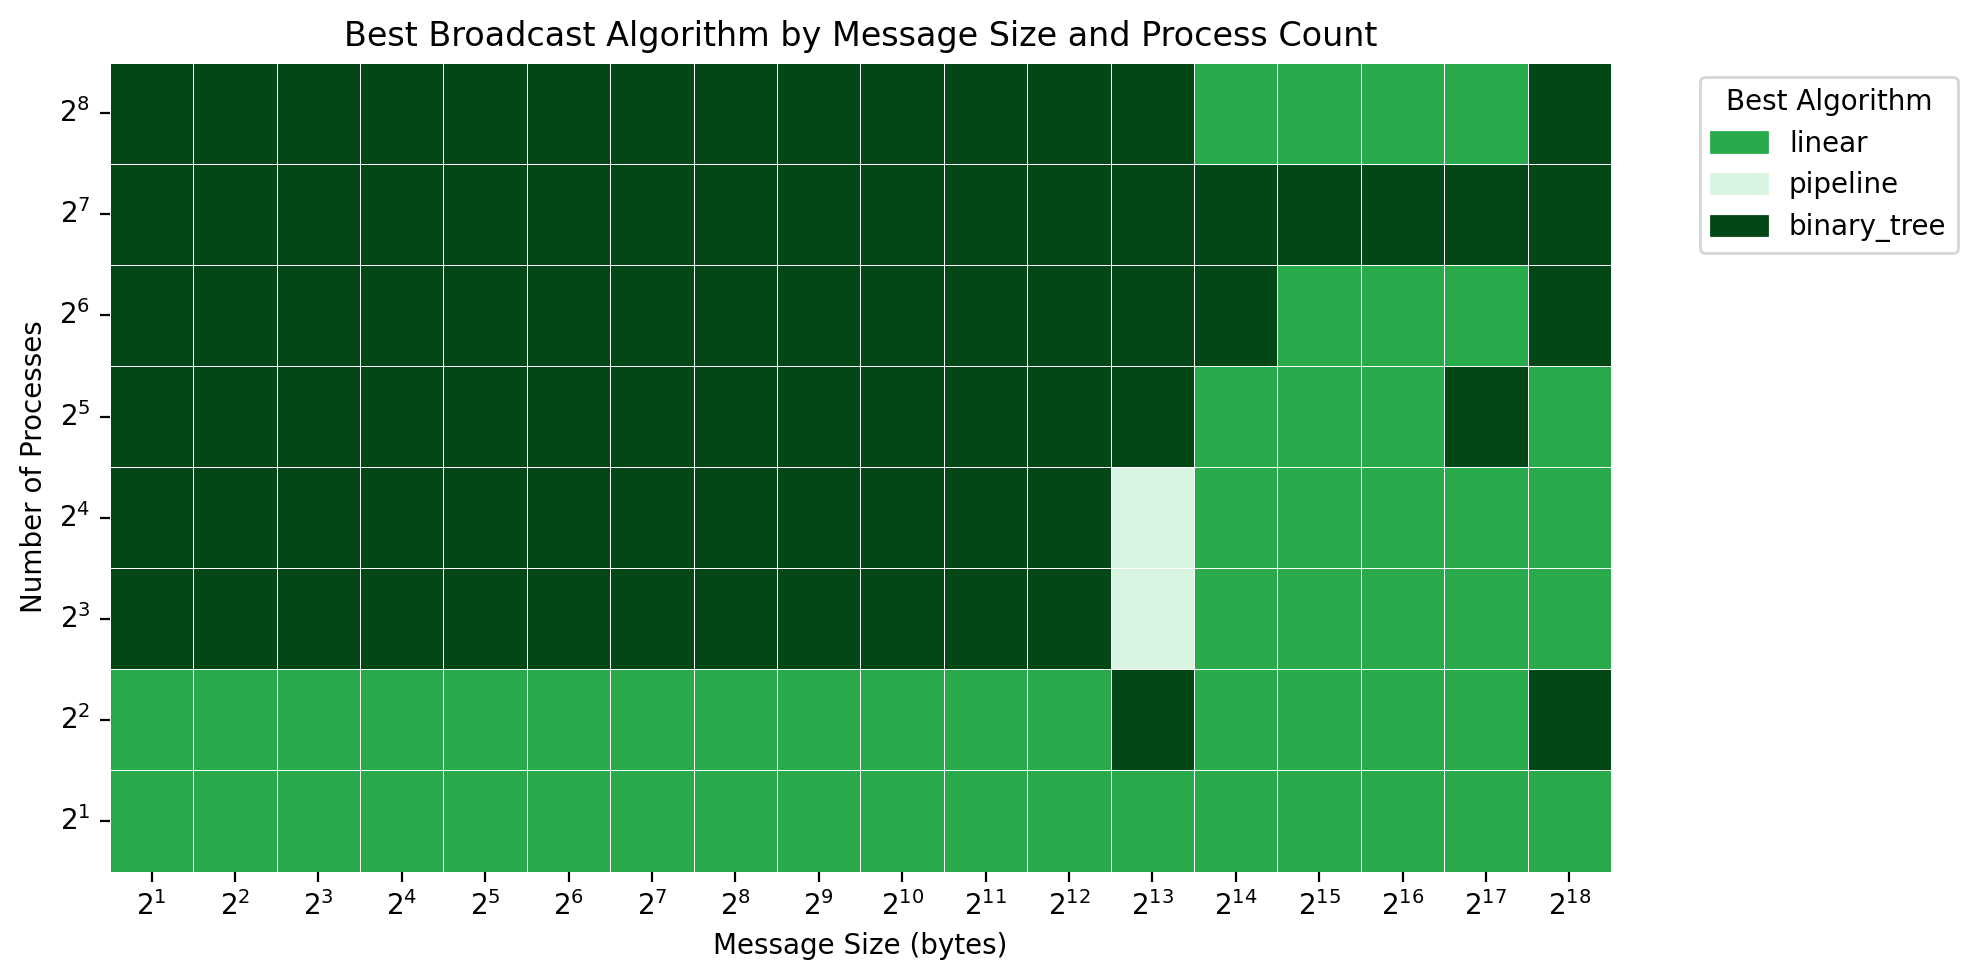

In [9]:
# Load the data for each algorithm
df_map1 = df_b_map1.copy()     # basic linear
df_map3 = df_b_map3.copy()     # pipeline
df_map5 = df_b_map5.copy()     # binary tree

# Rename columns for clarity
df_map1.rename(columns={'Latency': 'Latency_linear'}, inplace=True)
df_map3.rename(columns={'Latency': 'Latency_pipeline'}, inplace=True)
df_map5.rename(columns={'Latency': 'Latency_binary_tree'}, inplace=True)

# Merge datasets on Processes and Size
merged_df = df_map1.merge(df_map3, on=['Processes', 'Size']).merge(df_map5, on=['Processes', 'Size'])

# Find the best algorithm for each (Processes, Size) pair
def best_algorithm(row):
    latencies = {
        'linear': row['Latency_linear'],
        'pipeline': row['Latency_pipeline'],
        'binary_tree': row['Latency_binary_tree']
    }
    return min(latencies, key=latencies.get)  # Returns the algorithm with the minimum latency

merged_df['best_algorithm'] = merged_df.apply(best_algorithm, axis=1)

# Map the best algorithm to a numeric value for plotting
algorithm_mapping = {'linear': 1, 'pipeline': 2, 'binary_tree': 3}
merged_df['algorithm_code'] = merged_df['best_algorithm'].map(algorithm_mapping)

# Create a pivot table for the heatmap
heatmap_data = merged_df.pivot(index='Processes', columns='Size', values='algorithm_code')

# Define a color palette (customizing colors for each algorithm)
cmap = sns.color_palette(["#29ab4c", "#d7f5e0", "#024715",])  # Colors for linear, pipeline, binary_tree

# Plot the heatmap
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(heatmap_data, cmap=cmap, cbar=False, annot=False, fmt=".0f", linewidths=0.2)

# Customize labels and titles
plt.title('Best Broadcast Algorithm by Message Size and Process Count')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Number of Processes')

# Invert the y-axis
plt.gca().invert_yaxis()

# Format ticks to powers of 2
x_ticks = heatmap_data.columns
y_ticks = heatmap_data.index
plt.xticks(ticks=np.arange(len(x_ticks)) + 0.5, labels=[f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=-0)
plt.yticks(ticks=np.arange(len(y_ticks)) + 0.5, labels=[f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=-0)

# Custom legend
colors = [mpatches.Patch(color=cmap[i], label=list(algorithm_mapping.keys())[i]) for i in range(len(cmap))]
plt.legend(handles=colors, title="Best Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f'{out_dir}best_broadcast_algorithm.png')
plt.show()


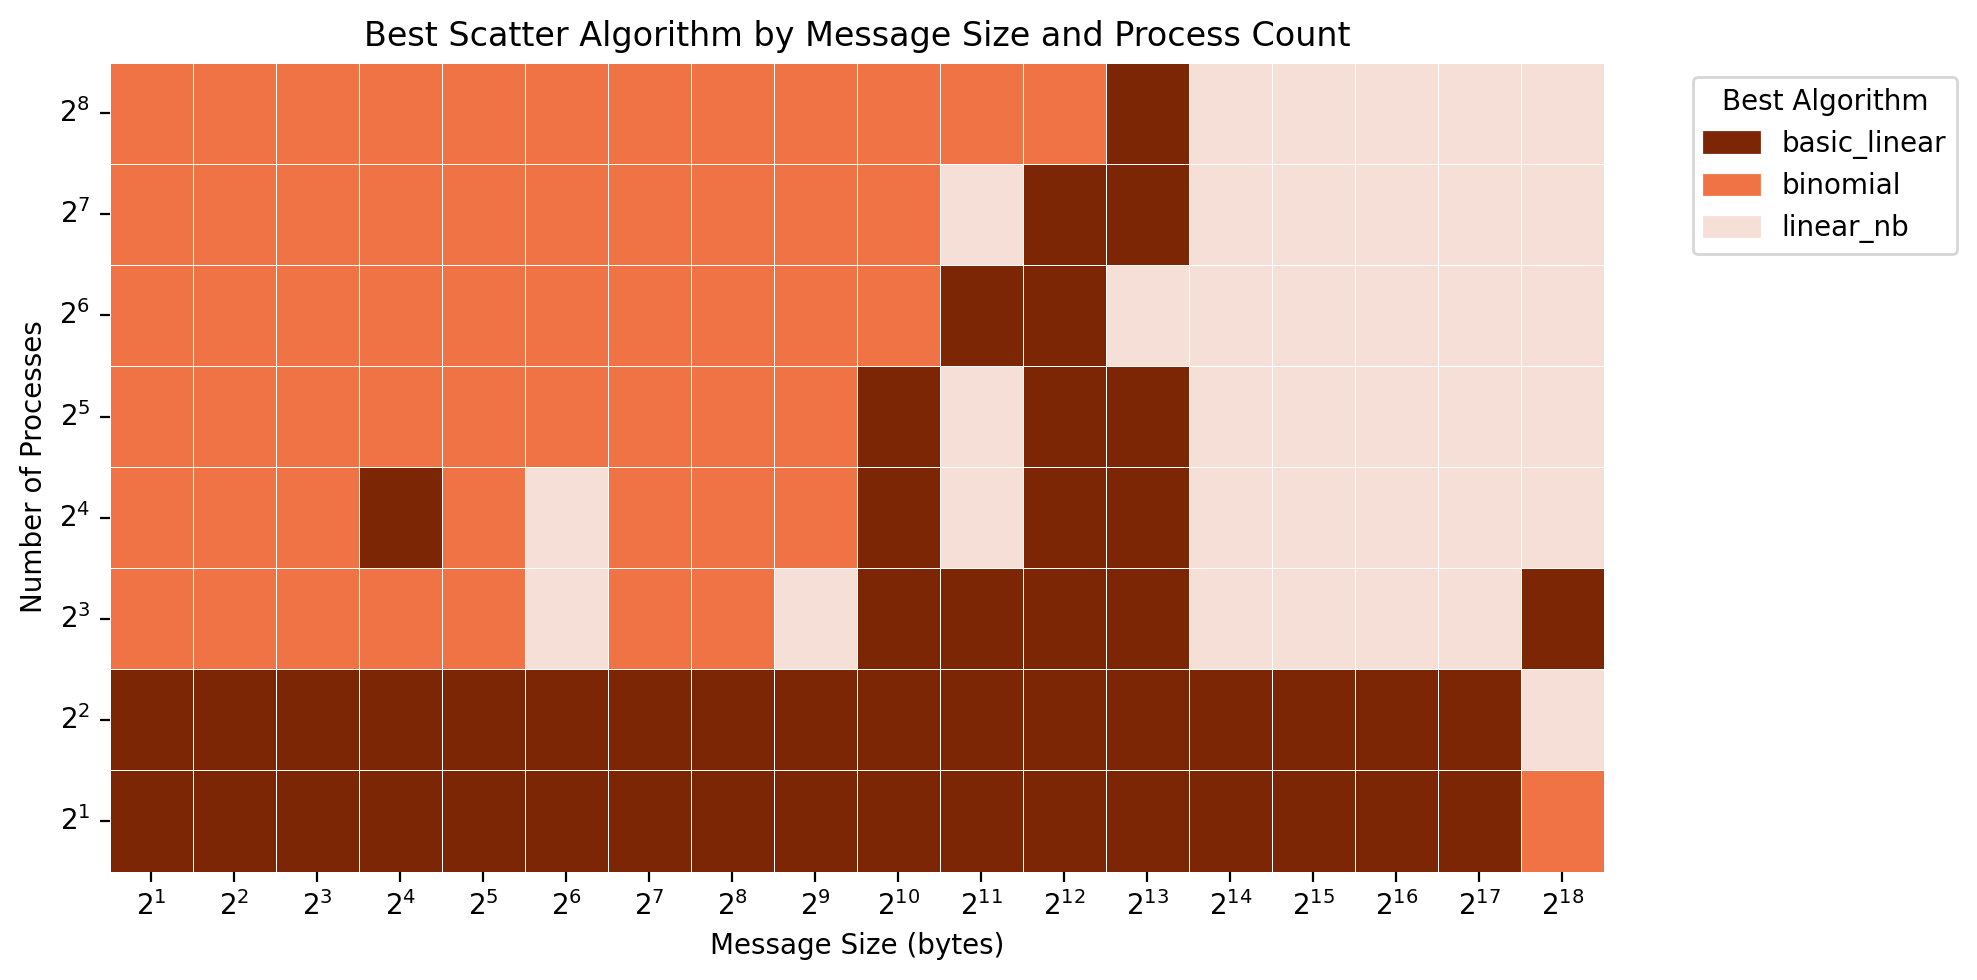

In [10]:

df_map1 = df_s_map1.copy()      # basic linear
df_map2 = df_s_map2.copy()      # binomial
df_map3 = df_s_map3.copy()      # linear_nb

# Rename columns for clarity
df_map1.rename(columns={'Latency': 'Latency_basic_linear'}, inplace=True)
df_map2.rename(columns={'Latency': 'Latency_binomial'}, inplace=True)
df_map3.rename(columns={'Latency': 'Latency_linear_nb'}, inplace=True)

# Merge datasets on Processes and Size
merged_df = df_map1.merge(df_map2, on=['Processes', 'Size']).merge(df_map3, on=['Processes', 'Size'])

# Find the best algorithm for each (Processes, Size) pair
def best_algorithm(row):
    latencies = {
        'basic_linear': row['Latency_basic_linear'],
        'binomial': row['Latency_binomial'],
        'linear_nb': row['Latency_linear_nb']
    }
    return min(latencies, key=latencies.get)  # Returns the algorithm with the minimum latency

merged_df['best_algorithm'] = merged_df.apply(best_algorithm, axis=1)

# Map the best algorithm to a numeric value for plotting
algorithm_mapping = {'basic_linear': 1, 'binomial': 2, 'linear_nb': 3}
merged_df['algorithm_code'] = merged_df['best_algorithm'].map(algorithm_mapping)

# Create a pivot table for the heatmap
heatmap_data = merged_df.pivot(index='Processes', columns='Size', values='algorithm_code')

# Define a color palette (customizing colors for each algorithm)
cmap = sns.color_palette(["#7d2606", "#f07346", "#f5dfd7",])  # Colors for linear, pipeline, binary_tree

# Plot the heatmap
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(heatmap_data, cmap=cmap, cbar=False, annot=False, fmt=".0f", linewidths=0.2)

# Customize labels and titles
plt.title('Best Scatter Algorithm by Message Size and Process Count')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Number of Processes')

# Invert the y-axis
plt.gca().invert_yaxis()

# Format ticks to powers of 2
x_ticks = heatmap_data.columns
y_ticks = heatmap_data.index
plt.xticks(ticks=np.arange(len(x_ticks)) + 0.5, labels=[f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=-0)
plt.yticks(ticks=np.arange(len(y_ticks)) + 0.5, labels=[f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=-0)

# Custom legend
colors = [mpatches.Patch(color=cmap[i], label=list(algorithm_mapping.keys())[i]) for i in range(len(cmap))]
plt.legend(handles=colors, title="Best Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f'{out_dir}best_scatter_algorithm.png')
plt.show()


In [11]:
def map3d_grid(df_maps, titles, out, colmap='viridis'):
    """
    Generates a 2x2 grid of 3D plots for four different datasets.

    Parameters:
        df_maps (list): List of four DataFrames containing the data to plot.
        titles (list): List of four titles to use for each plot.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=200, subplot_kw={'projection': '3d'})
    axs = axs.flatten() 

    for i, (df_map, title) in enumerate(zip(df_maps, titles)):
        ax = axs[i]
        
        # Log transform of 'Processes' and 'Size'
        x = np.log2(df_map['Processes'])
        y = np.log2(df_map['Size'])
        z = np.log2(df_map['Latency'])
        
        # Data preparation for interpolating the plane with logarithmic variables
        xi = np.linspace(x.min(), x.max(), 50)
        yi = np.linspace(y.min(), y.max(), 50)
        xi, yi = np.meshgrid(xi, yi)

        ax.plot_trisurf(x, y, z, cmap=colmap, edgecolor='black', alpha=0.8)
        
        ax.set_xlim(ax.get_xlim()[::-1])
        
        process_ticks = np.arange(x.min(), x.max() + 1, 1)
        size_ticks = np.arange(0, 19, 3)
        
        ax.set_xticks(process_ticks)
        ax.set_xticklabels([f"$2^{{{int(tick)}}}$" for tick in process_ticks])
        ax.set_yticks(size_ticks)
        ax.set_yticklabels([f"$2^{{{int(tick)}}}$" for tick in size_ticks])
        
        ax.view_init(elev=20, azim=320)
        
        ax.set_xlabel('Number of Processes', fontsize=7)
        ax.set_ylabel('Message Size (bytes)')
        
        mappable = cm.ScalarMappable(cmap=colmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
        mappable.set_array(z)
        fig.colorbar(mappable, ax=ax, label='$\\log_2$(Avg Latency $(\\mu s)$)', shrink=0.6, pad=0.15)
        
        ax.set_title(title)
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
    plt.savefig(f'{out_dir}/{out}')
    plt.show()



In [12]:
# scatter
sc_df_maps = [df_s_map0, df_s_map1, df_s_map2, df_s_map3]
sc_titles = ["Scatter Latency\nmap-by core, default algorithm", "Scatter Latency\nmap-by core, basic_linear algorithm", "Scatter Latency\nmap-by core, binomial algorithm",
           "Scatter Latency\nmap-by core, linear_nb algorithm"]
# broadcast
bc_df_maps = [df_b_map0, df_b_map1, df_b_map3, df_b_map5]
bc_titles = ["Broadcast Latency\nmap-by core, default algorithm", "Broadcast Latency\nmap-by core, basic_linear algorithm", "Broadcast Latency\nmap-by core, pipeline algorithm",
           "Broadcast Latency\nmap-by core, binary_tree algorithm"]

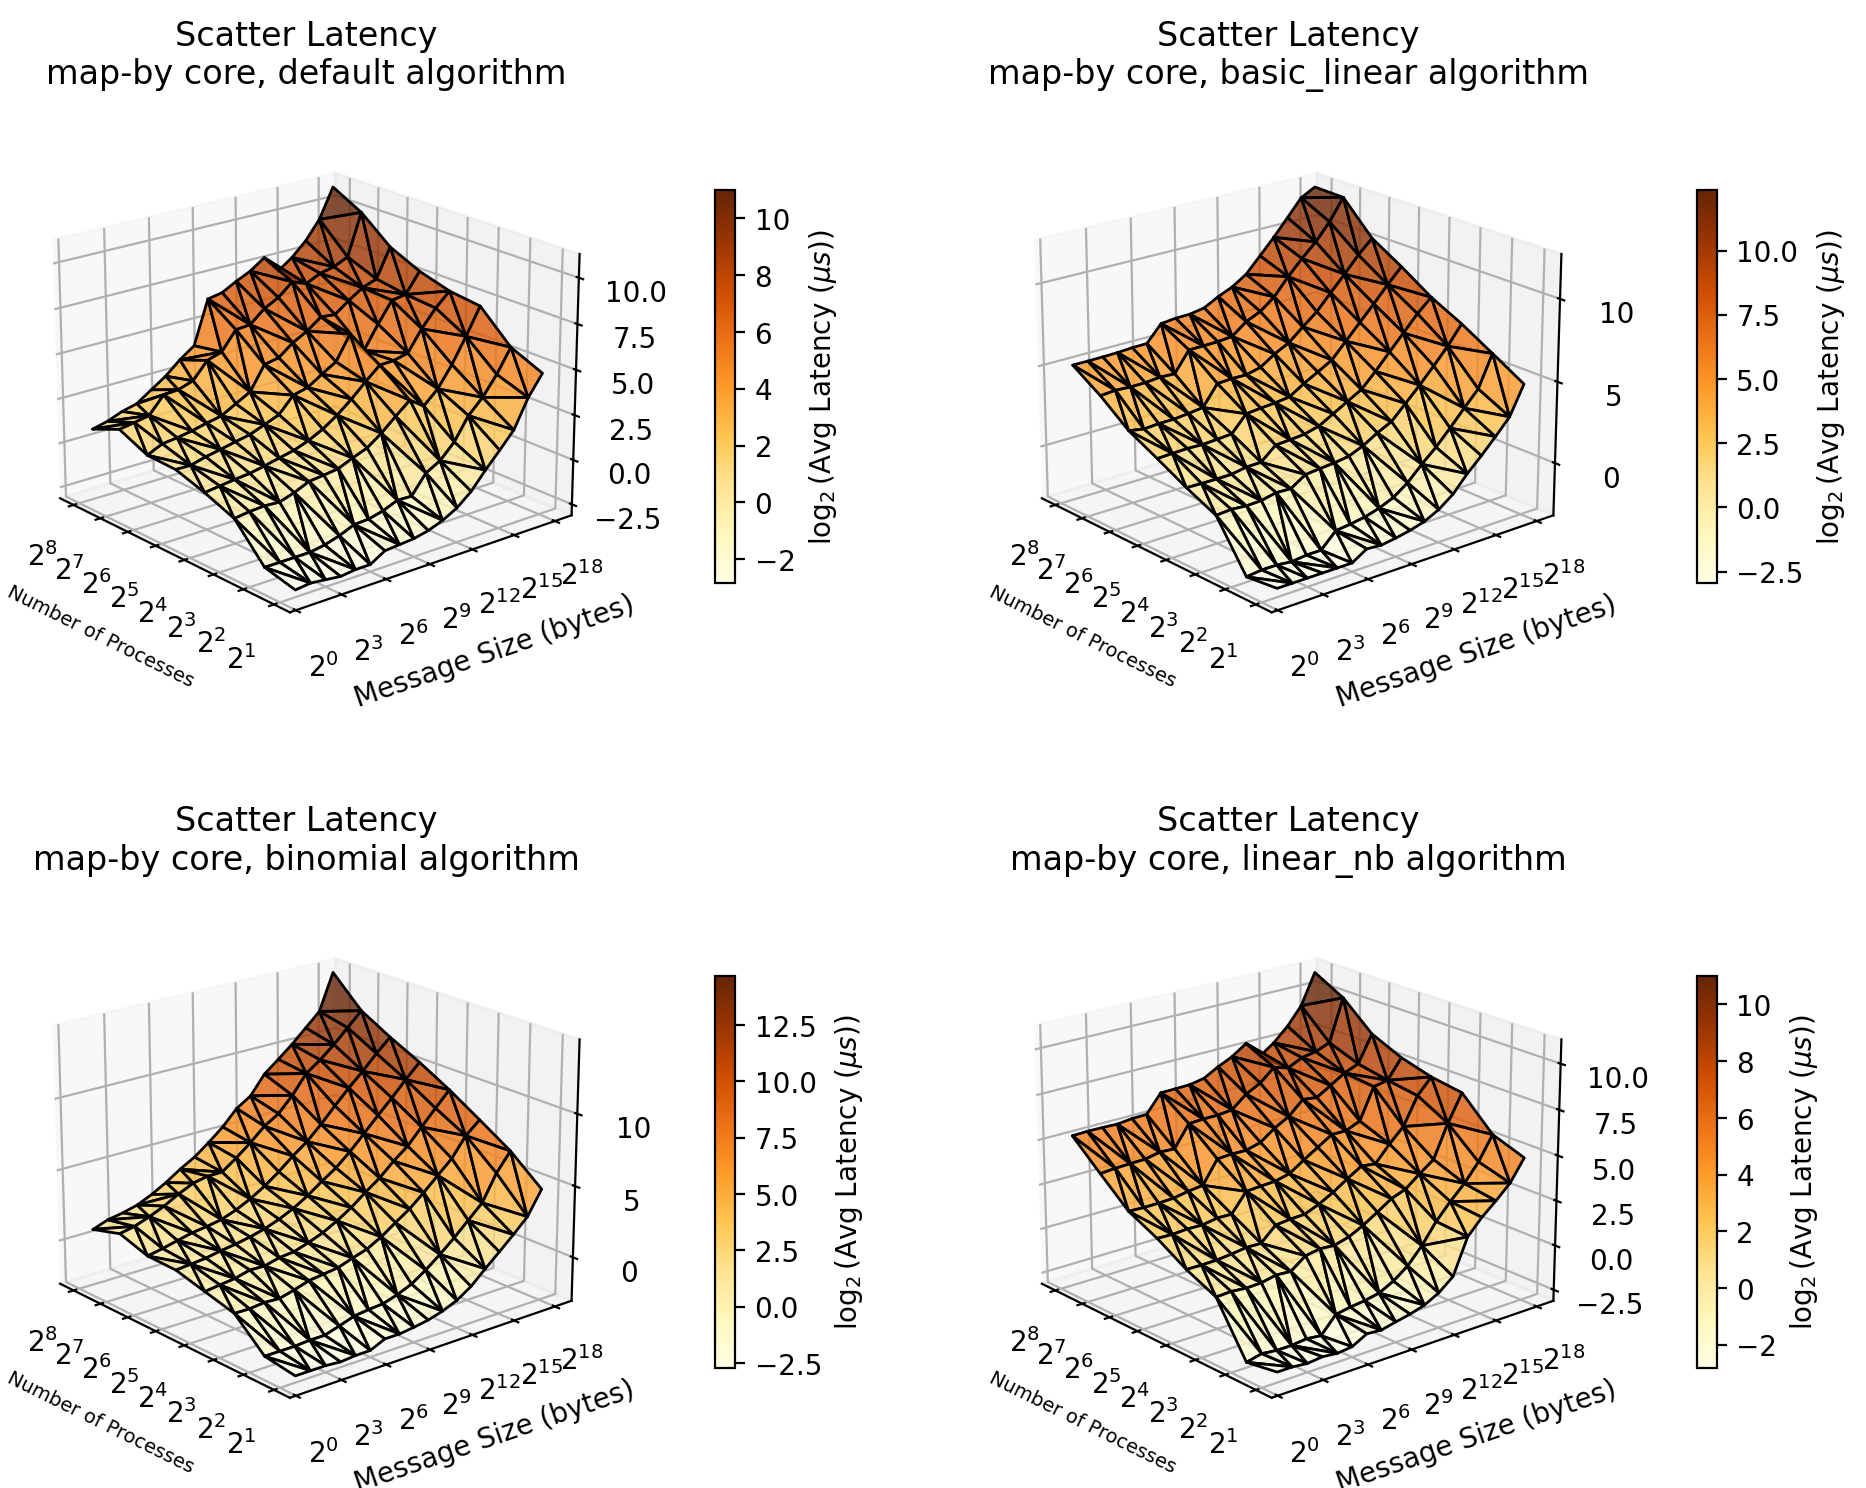

In [13]:
map3d_grid(sc_df_maps, sc_titles,'scatter_map_by_core.png', 'YlOrBr')

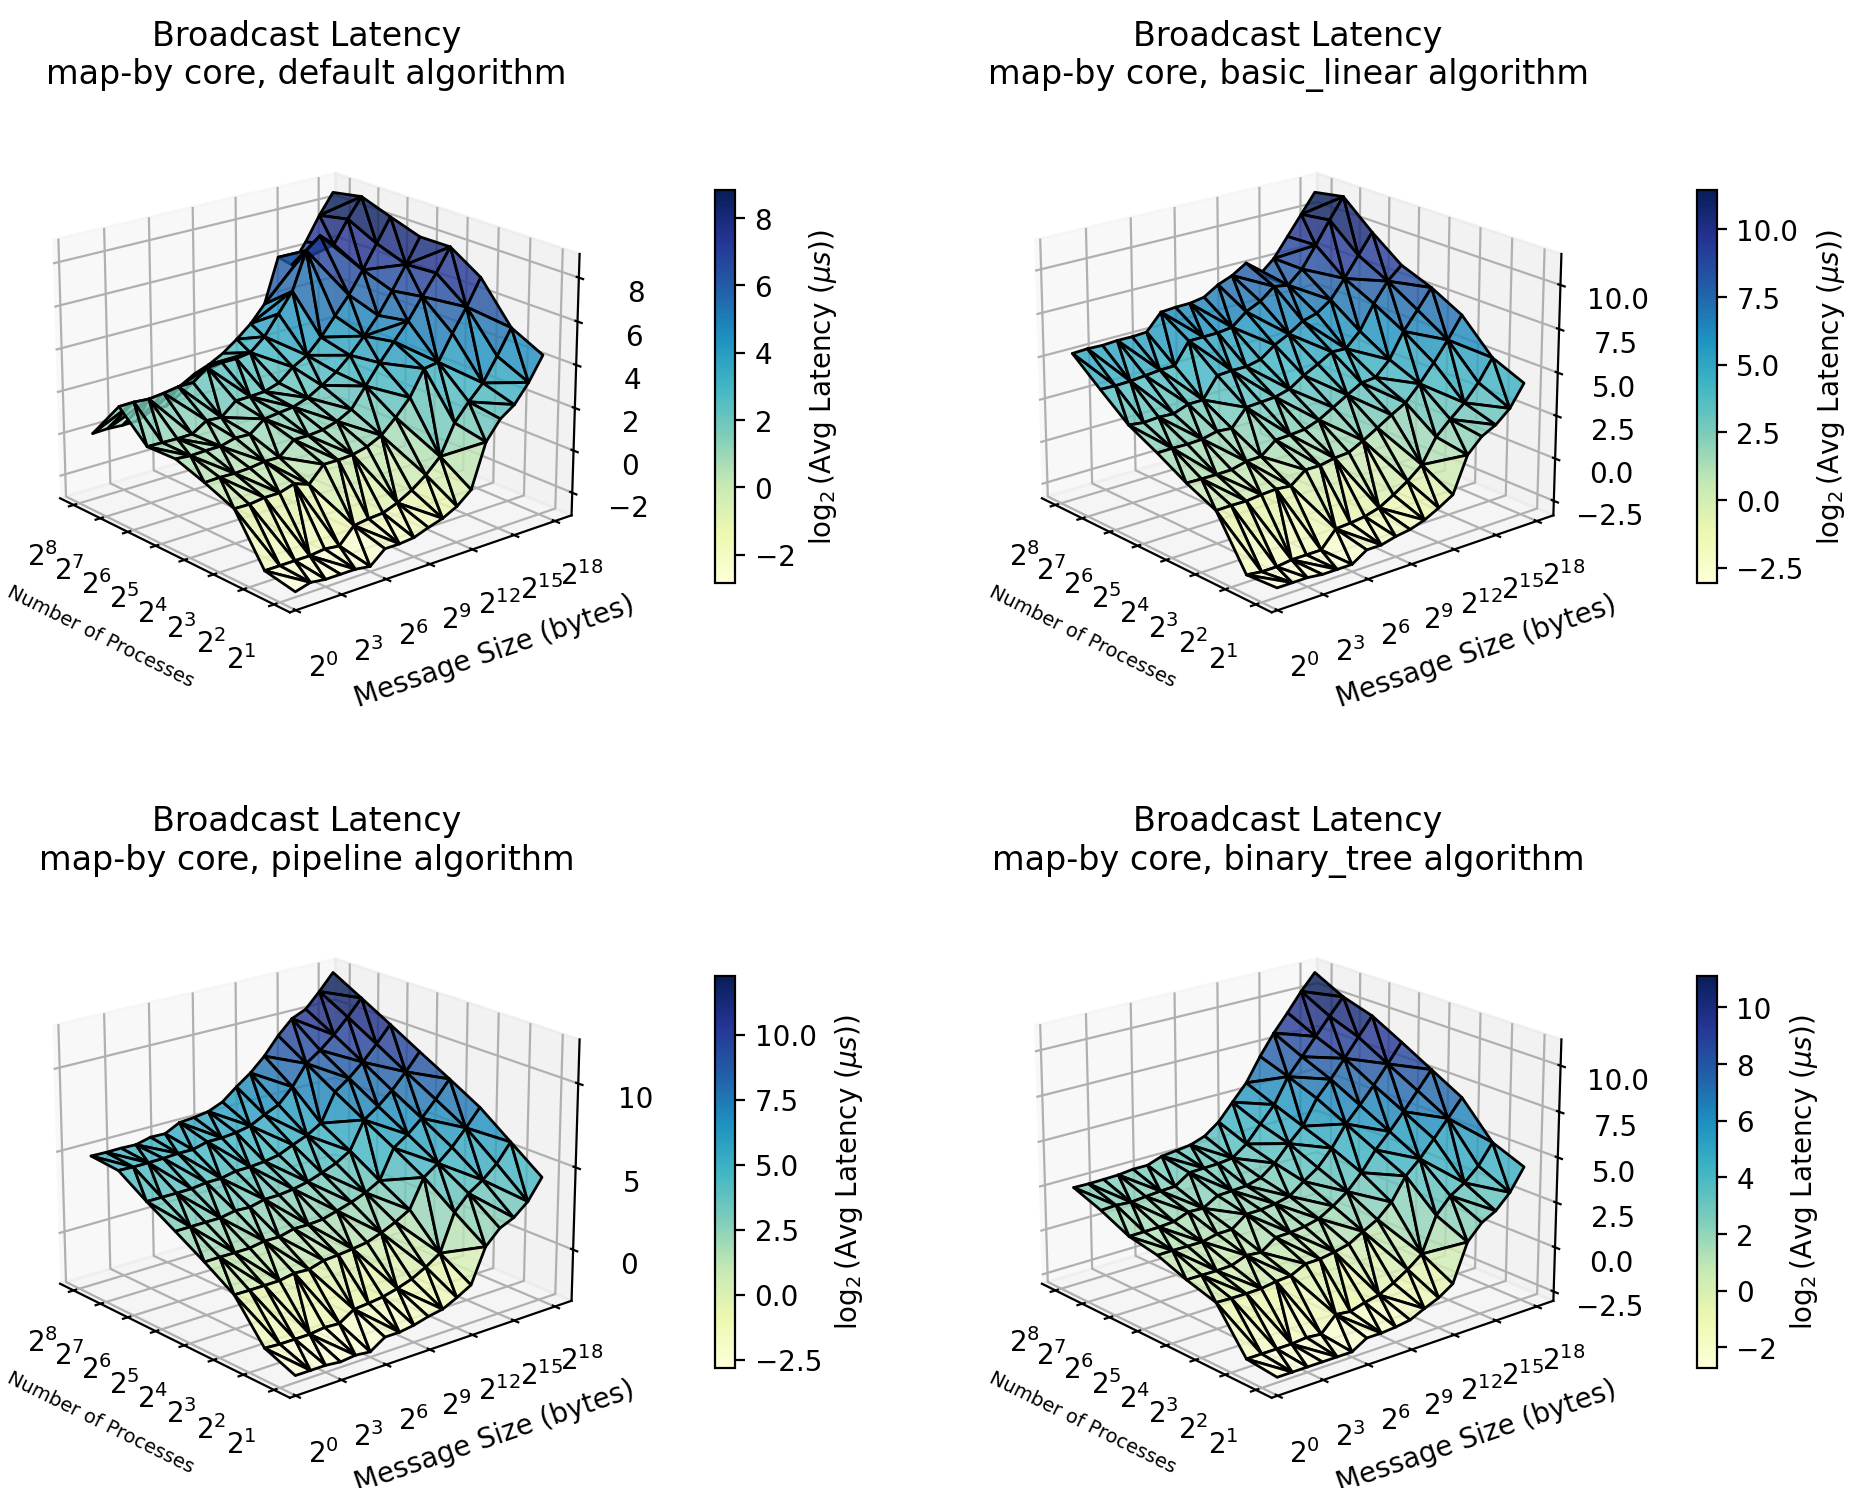

In [14]:
map3d_grid(bc_df_maps, bc_titles, 'broadcast_map_by_core.png','YlGnBu')

In [15]:
# --- PIPELINE  and BASIC LINEAR MODEL ---

# Latencies in seconds
LATENCY_CCX = 0.15e-6 
LATENCY_CCD_DIFF_CCX = 0.31e-6 
LATENCY_NUMA = 0.34e-6 
LATENCY_SOCKET = 0.36e-6 
LATENCY_DIFF_SOCKET = 0.65e-6 
LATENCY_DIFF_NODE = 1.82e-6 

# Latencies in microseconds
latency_p2p = {
    "same_CCX": LATENCY_CCX*1e6,
    "same_CCD_different_CCX": LATENCY_CCD_DIFF_CCX*1e6,
    "same_NUMA": LATENCY_NUMA*1e6,
    "same_SOCKET": LATENCY_SOCKET*1e6,
    "different_SOCKET": LATENCY_DIFF_SOCKET*1e6,
    "different_NODE": LATENCY_DIFF_NODE*1e6
}

# This function determines the relationship between two cores (i, i+1) returning the appropriate latency
def determine_latency(i, j):
    # We simulate the logic of the core topology and assign the appropriate latency
    if i // 4 == j // 4:  
        return latency_p2p["same_CCX"]
    elif i // 8 == j // 8:  
        return latency_p2p["same_CCD_different_CCX"]
    elif i // 32 == j // 32:  
        return latency_p2p["same_NUMA"]
    elif i // 64 == j // 64:  # 
        return latency_p2p["same_SOCKET"]
    elif i // 128 == j // 128:  
        return latency_p2p["different_SOCKET"]
    else:
        return latency_p2p["different_NODE"]
    
# This function determines the parallelism discount for the basic linear model
def par_disc(i):
    if i in range(0,4):  
        return 0.4
    elif i in range(4,8):  
        return 0.35
    elif i in range(8,32):  
        return 0.3
    elif i in range(32,64): 
        return 0.25
    elif i in range(64,128):  
        return 0.2
    else:
        return 0.12

# Latency calculation T(n) for each core from 0 to 256
def calculate_latency(n):
    total_latency = 0
    for i in range(n):
        total_latency += determine_latency(i, i+1)
    return total_latency

def calculate_bs_latency(n):
    total_latency = 0
    for i in range(n):
        total_latency += determine_latency(0, i+1)*par_disc(i)
    return total_latency

pip_model = [calculate_latency(n) for n in range(256)]
bs_lin_model = [calculate_bs_latency(n) for n in range(256)]

In [16]:
# --- BINARY TREE MODEL ---

# succ_left and succ_right functions to calculate the left and right children of a node in a binary tree
def succ_left(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**(h+1) - 1 + i

def succ_right(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**h + 2**(h+1) - 1 + i


# 2 SOCKET
# 4 NUMA REGION x SOCKET
# 8 CCD x NUMA REGION
# 2 CCX x CCD

MATRIX_TIMES = np.zeros((255, 255), dtype=np.float32)
for i in range(255):
  for j in range(255):
    if i == j:
      MATRIX_TIMES[i][j] = 0
    elif i//4 == j//4:
      MATRIX_TIMES[i][j] = LATENCY_CCX
    elif i//16 == j//16:
      MATRIX_TIMES[i][j] = LATENCY_CCD_DIFF_CCX
    elif i//32 == j//32:
      MATRIX_TIMES[i][j] = LATENCY_NUMA
    elif i//64 == j//64:
      MATRIX_TIMES[i][j] = LATENCY_SOCKET
    elif i//128 == j//128:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_SOCKET
    else:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_NODE

NON_OVERLAP_FACTOR = 0.4e-2
TOTAL_PROC_FACTOR = 1.5e-4 * 1e-6

# The model calculates the latency for a binary tree with n_proc processors using the matrix of latencies
# The computation is done in log2(n_proc) steps where at each step the maximum latency is calculated
# The latency is calculated as the maximum latency of the two children plus the latency of the parent
# The latency of the parent is multiplied by a factor NON_OVERLAP_FACTOR to account for non-overlapping communication
# The latency of the root is multiplied by a factor TOTAL_PROC_FACTOR to account for the total number of processors and an offset is added to the final result

def bin_tree_latency(n_proc):
    time = 0
    for j in range(1, math.floor(math.log2(n_proc)) + 1):
        step_j = []
        for k in range(j - 1, math.floor(math.log2(n_proc))):
            left = succ_left(k)
            right = succ_right(k)
            step_j.append(MATRIX_TIMES[k][left] + MATRIX_TIMES[k][right])
        time += max(step_j) * ( 1 + 2**(j + 1) * NON_OVERLAP_FACTOR )
    time += n_proc**2 * TOTAL_PROC_FACTOR - 1e-6
    return time

n_proc = list(range(1, 257))
binary_tree_latencies = np.array([bin_tree_latency(N) for N in n_proc]) *1e6


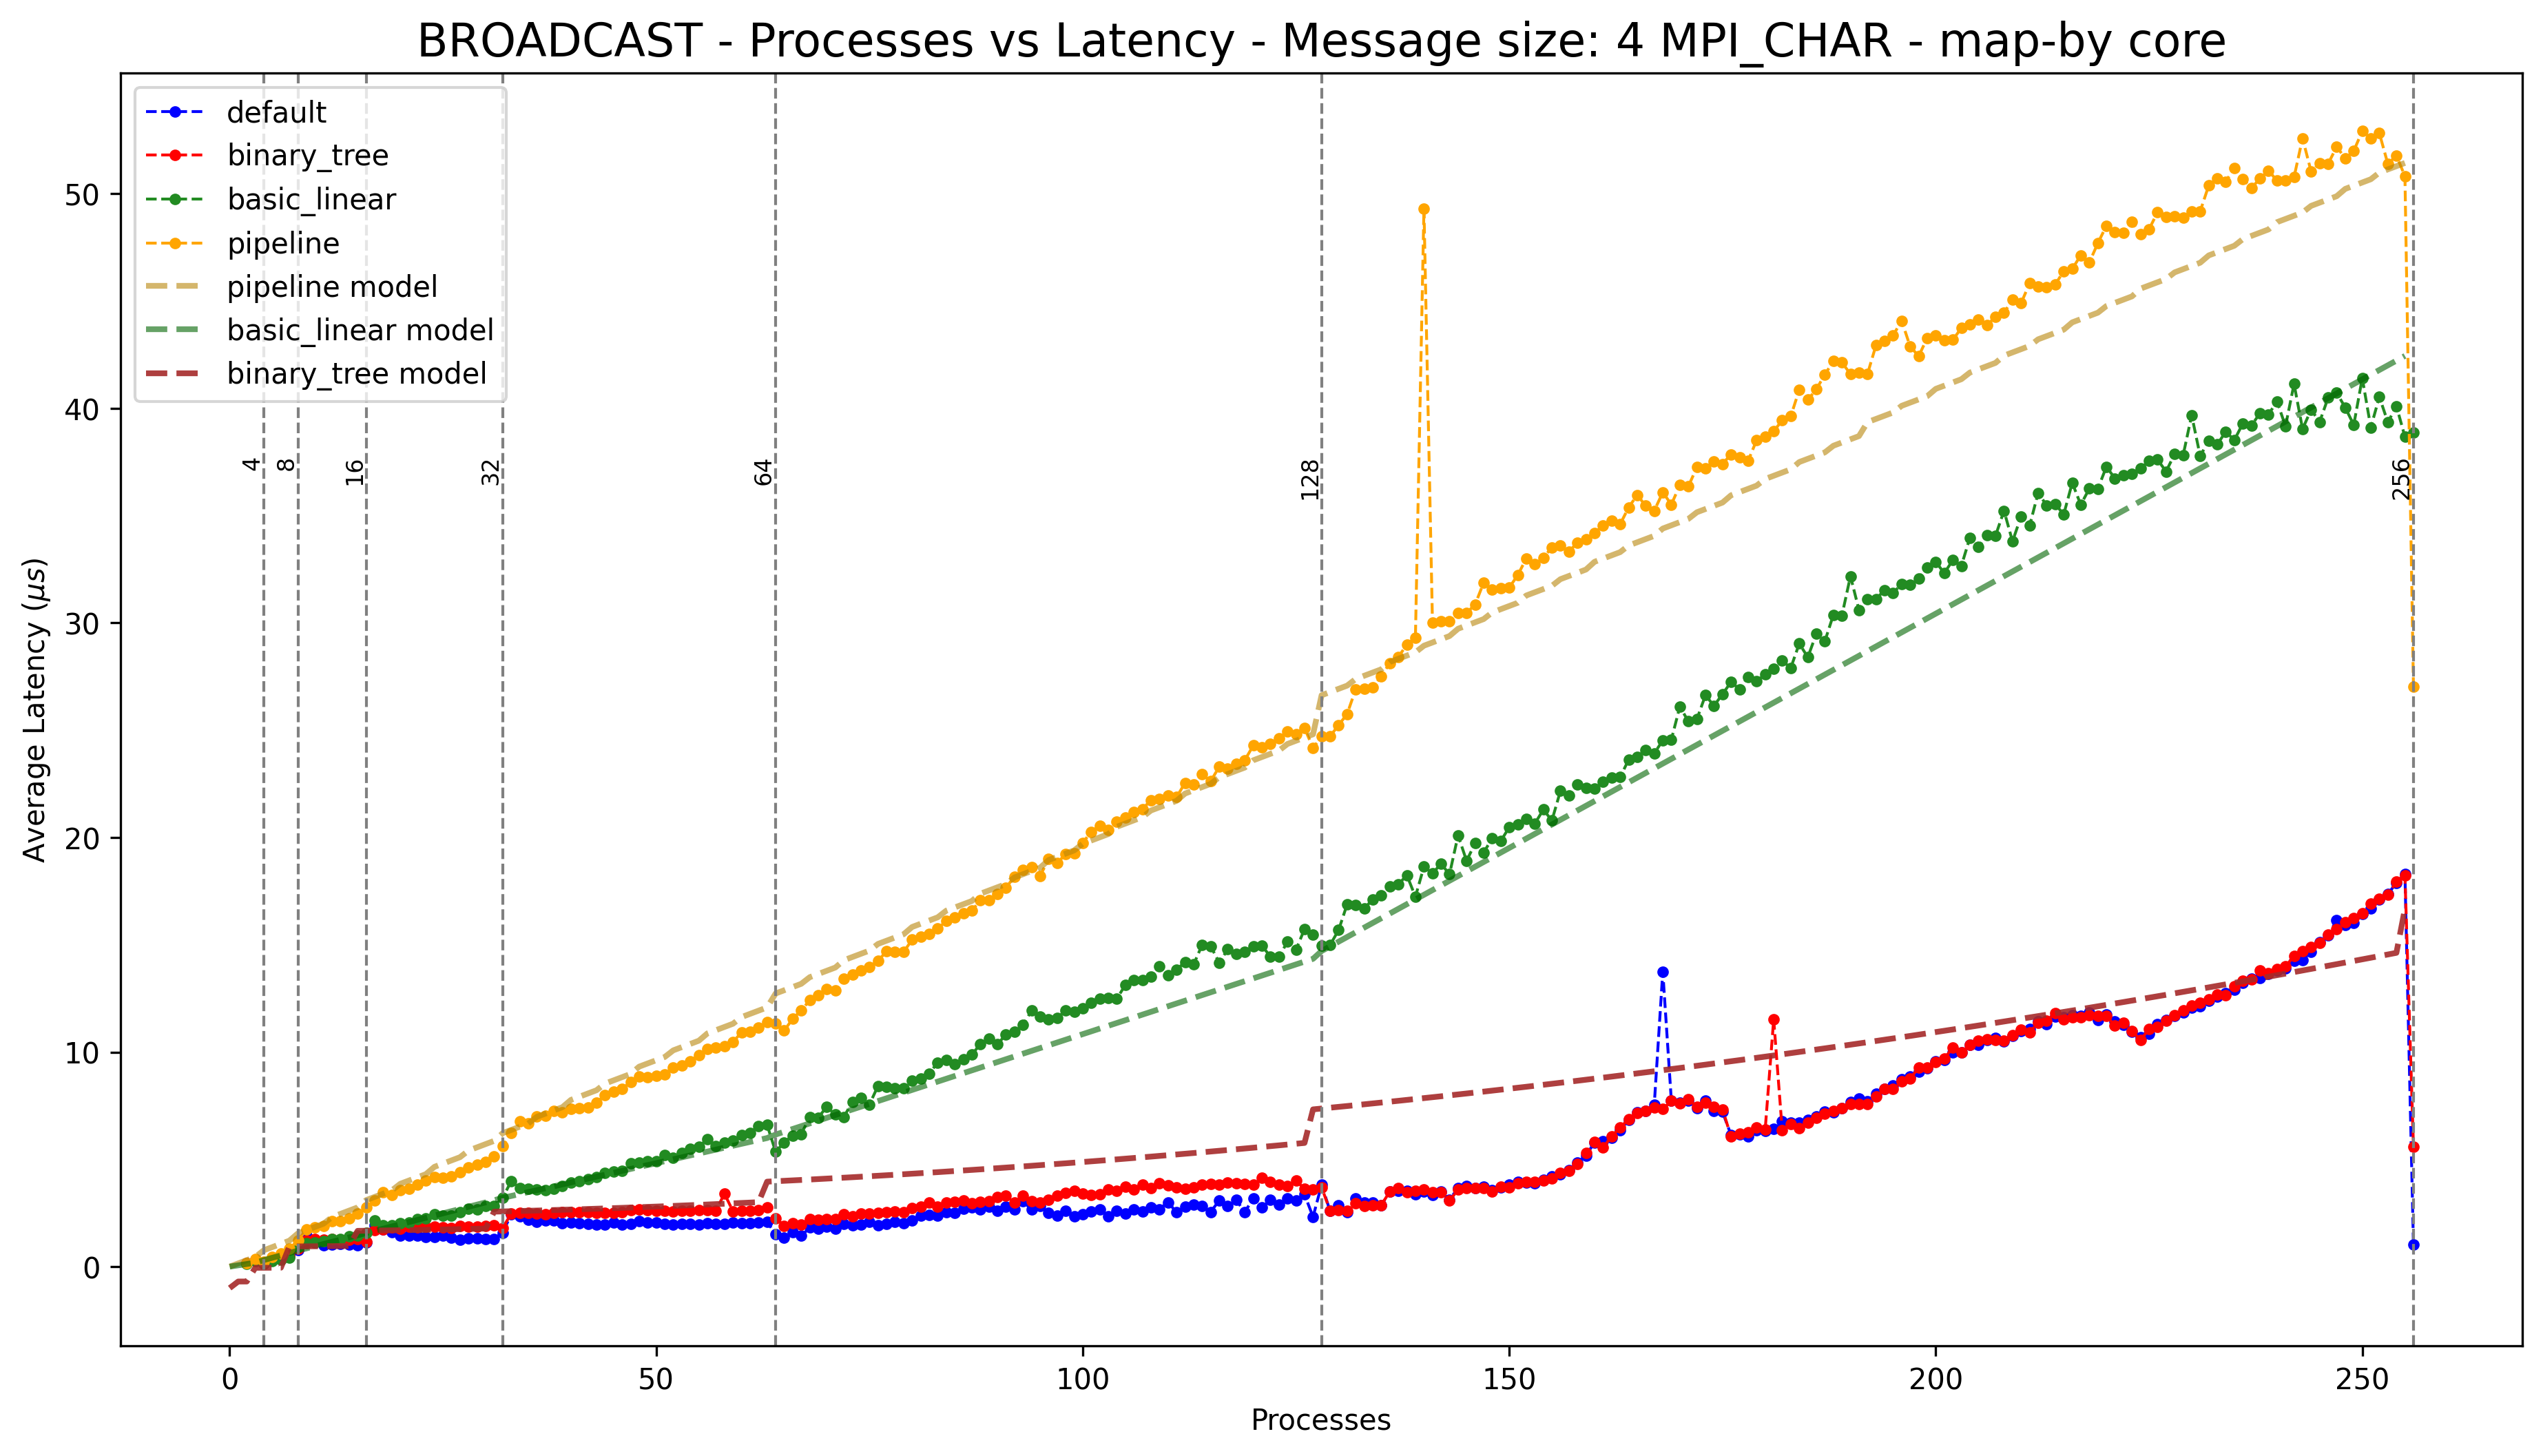

In [17]:
x = np.arange(256)

plt.figure(figsize=(15, 8), dpi=300)
# 1:"basic_linear", 2:"binomial", 3:"linear_nb"

plt.plot(b_df0['Processes'], b_df0['Latency'], marker='o', color='blue', linestyle='dashed', linewidth=1, markersize=3, label='default')
plt.plot(b_df5['Processes'], b_df5['Latency'], marker='o', color='red', linestyle='dashed', linewidth=1, markersize=3, label='binary_tree')
plt.plot(b_df1['Processes'], b_df1['Latency'], marker='o', color='forestgreen', linestyle='dashed', linewidth=1, markersize=3, label='basic_linear')
plt.plot(b_df3['Processes'], b_df3['Latency'], marker='o', color='orange', linestyle='dashed', linewidth=1, markersize=3, label='pipeline')

plt.plot(x, pip_model, marker='', color='darkgoldenrod', linestyle='--', linewidth=2, label='pipeline model', alpha = 0.6)
plt.plot(x, bs_lin_model, marker='', color='darkgreen', linestyle='--', linewidth=2, label='basic_linear model', alpha = 0.6)
plt.plot(x, binary_tree_latencies, marker='', color='brown', linestyle='--', linewidth=2, label='binary_tree model', alpha = 0.9)


for i in range(2, 9):
    x_position = 2**i
    plt.axvline(x=x_position, color='grey', linestyle='--', linewidth=1)
    plt.text(x_position, plt.ylim()[1]*0.68, f'{x_position}', ha='right', va='top', rotation=90, color='black', fontsize=8)


plt.xlabel('Processes')
plt.ylabel('Average Latency $(\\mu s)$')
plt.title('BROADCAST - Processes vs Latency - Message size: 4 MPI_CHAR - map-by core', size=16)
plt.legend(loc='upper left')

plt.savefig(f'{out_dir}broadcast_models.png')
plt.show()

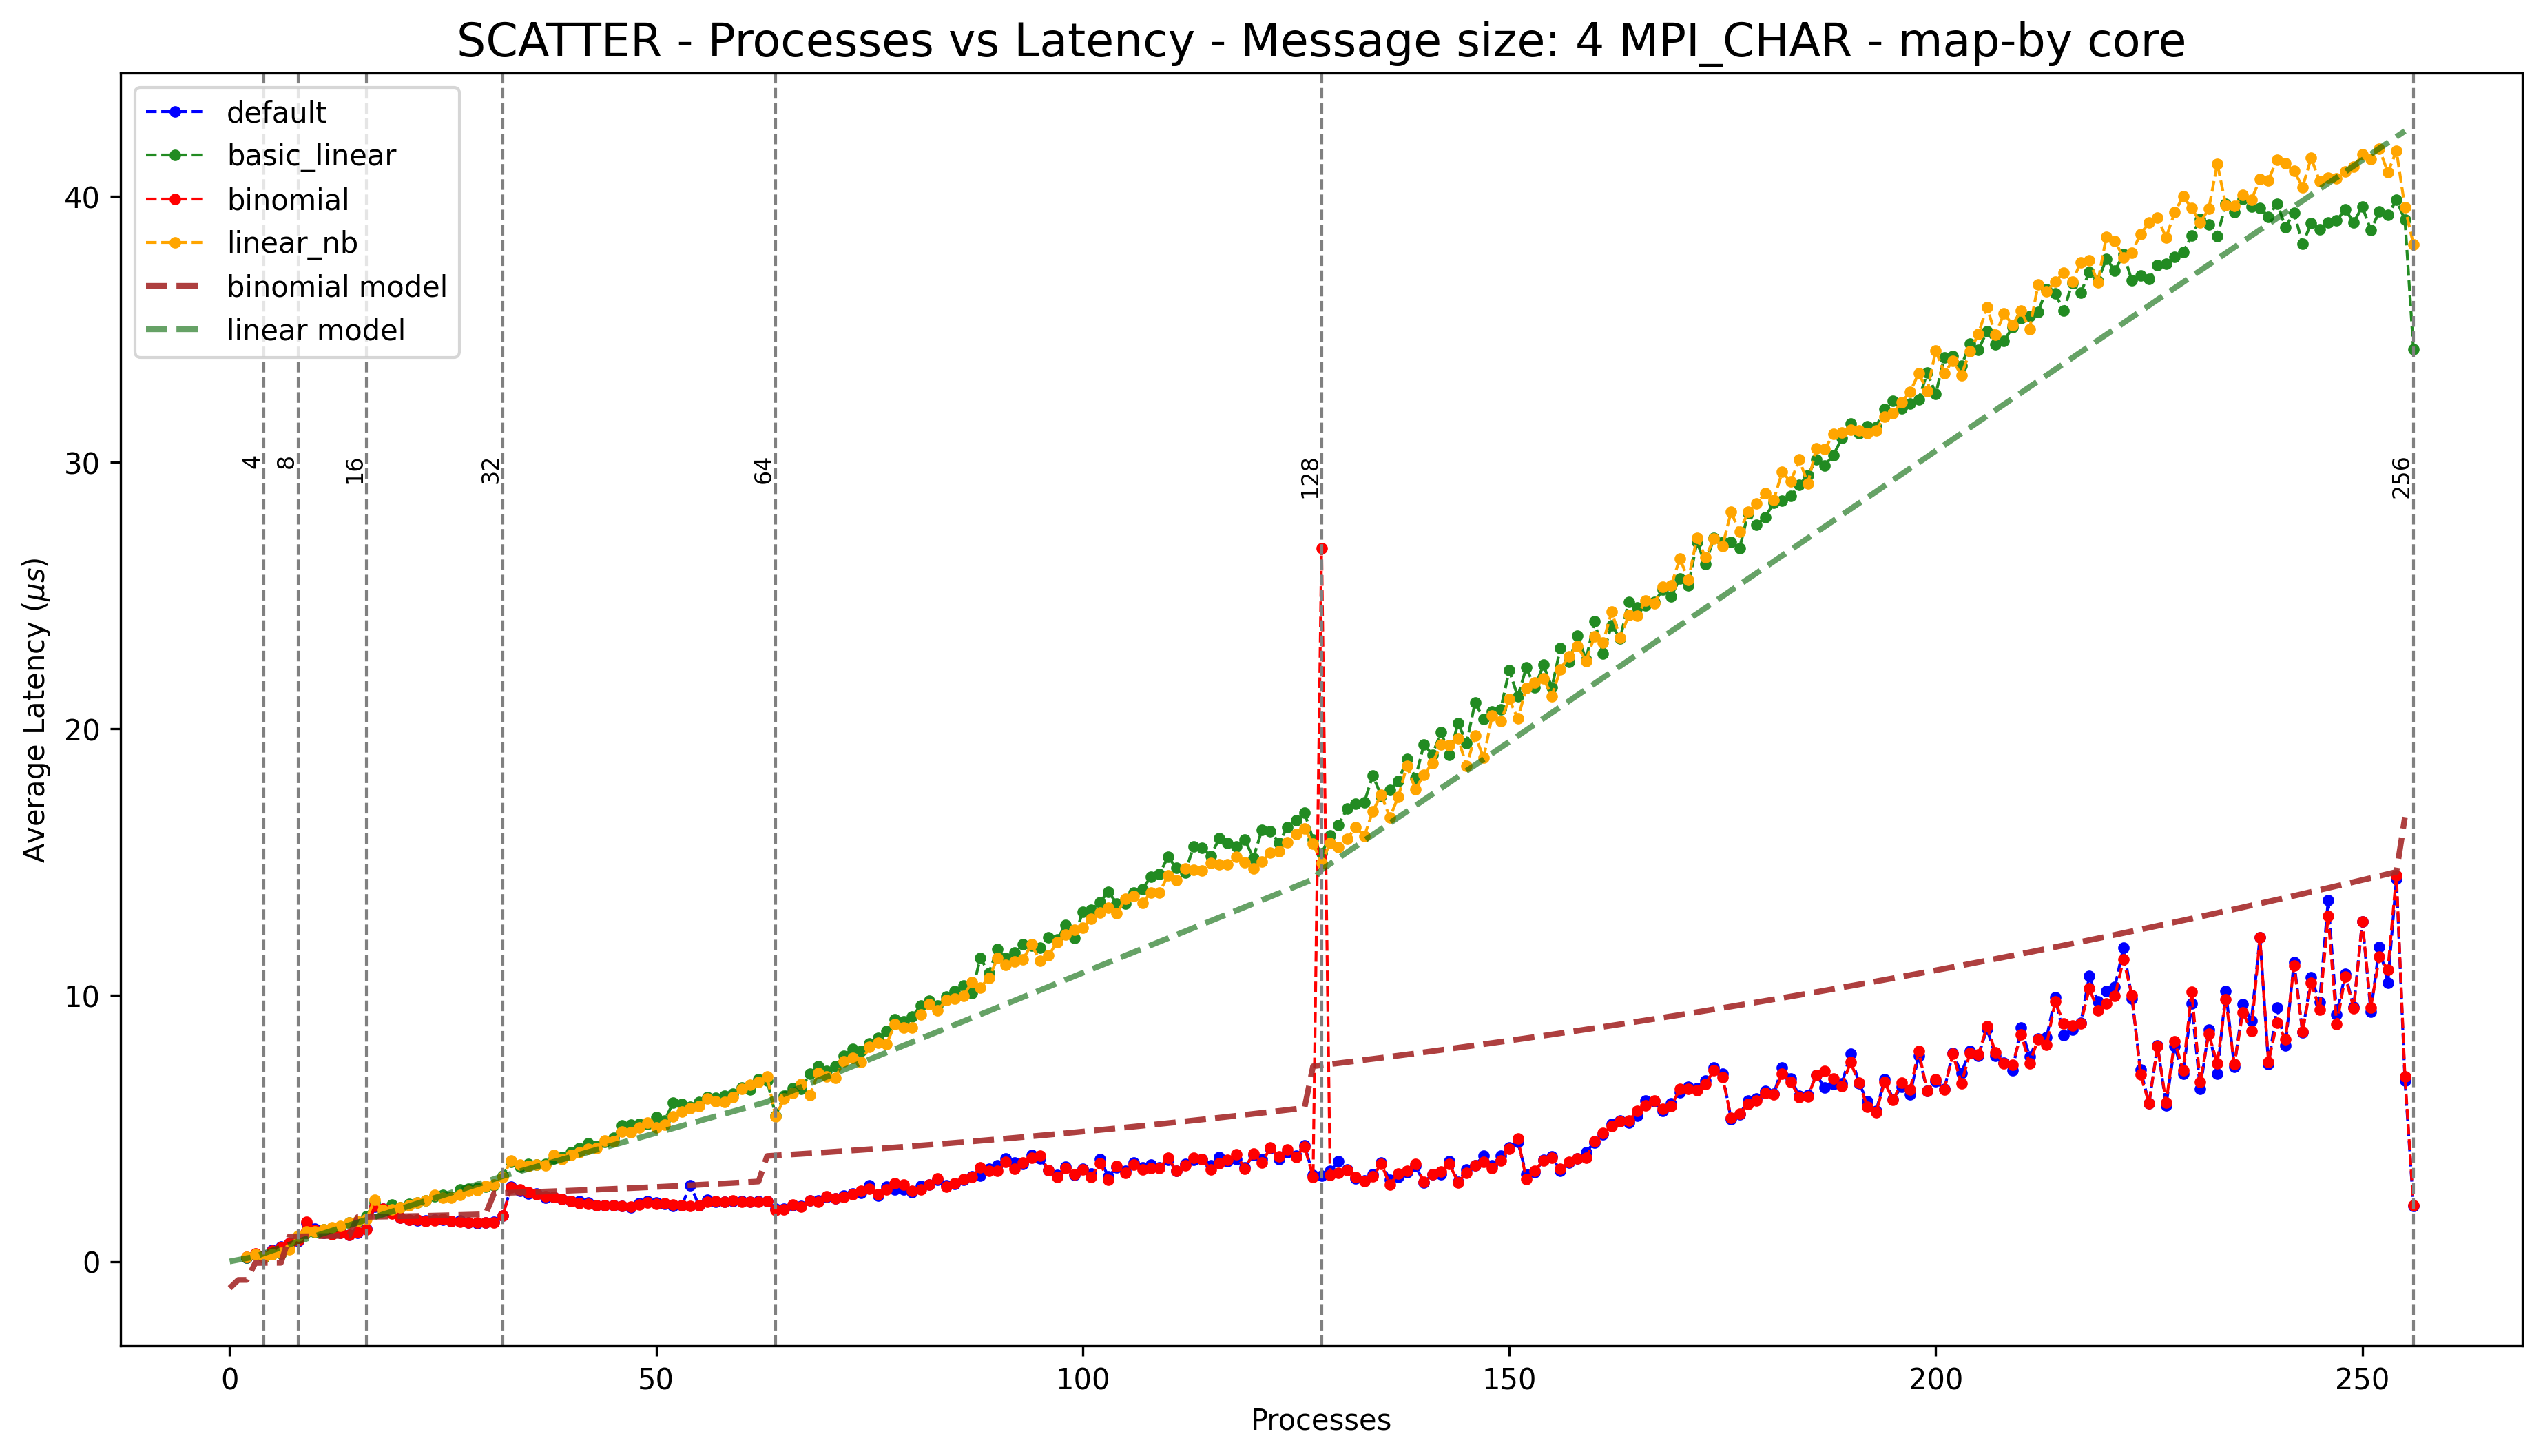

In [18]:
plt.figure(figsize=(15, 8), dpi=300)
# 1:"basic_linear", 2:"binomial", 3:"linear_nb"
plt.plot(s_df0['Processes'], s_df0['Latency'], marker='o', color='blue', linestyle='dashed', linewidth=1, markersize=3, label='default')
plt.plot(s_df1['Processes'], s_df1['Latency'], marker='o', color='forestgreen', linestyle='dashed', linewidth=1, markersize=3, label='basic_linear')
plt.plot(s_df2['Processes'], s_df2['Latency'], marker='o', color='red', linestyle='dashed', linewidth=1, markersize=3, label='binomial')
plt.plot(s_df3['Processes'], s_df3['Latency'], marker='o', color='orange', linestyle='dashed', linewidth=1, markersize=3, label='linear_nb')
plt.plot(x, binary_tree_latencies, marker='', color='brown', linestyle='--', linewidth=2, label='binomial model', alpha = 0.9) #ADRIANO
plt.plot(x, bs_lin_model, marker='', color='darkgreen', linestyle='--', linewidth=2, label='linear model', alpha = 0.6)

for i in range(2, 9):
    x_position = 2**i
    plt.axvline(x=x_position, color='grey', linestyle='--', linewidth=1)
    plt.text(x_position, plt.ylim()[1]*0.68, f'{x_position}', ha='right', va='top', rotation=90, color='black', fontsize=8)

plt.xlabel('Processes')
plt.ylabel('Average Latency $(\\mu s)$')
plt.title('SCATTER - Processes vs Latency - Message size: 4 MPI_CHAR - map-by core', size=16)
plt.legend(loc='upper left')

plt.savefig(f'{out_dir}scatter_models.png')
plt.show()